In [1]:
import numpy as np

import matplotlib.pyplot as plt

In [2]:
argwhere     = np.argwhere
float64      = np.float64
full         = np.full
hstack       = np.hstack
int          = np.int
fromfunction = np.fromfunction
linspace     = np.linspace
meshgrid     = np.meshgrid
vstack       = np.vstack
where        = np.where
zeros        = np.zeros

linear_solve = np.linalg.solve

In [3]:
def Display(A, cmap='cividis'):
    
    plt.figure(figsize=(10,10));
    plt.imshow(A[::-1], extent=[0, 1.61, 0, 1.61], cmap=cmap);
    plt.colorbar();

In [4]:
n = 100
h = 1/(n-1)

In [5]:
L = linspace(0, 1.61, n)

In [6]:
G = meshgrid(L, L)

In [7]:
X = G[0]
Y = G[1]

In [8]:
Plaster_1 = where((X >= .00) & (Y >= .00) & ((X < .02) | (Y < .02)), .810, 0)
Isolation = where((X >= .02) & (Y >= .02) & ((X < .14) | (Y < .14)), .049, 0)
Porotherm = where((X >= .14) & (Y >= .14) & ((X < .59) | (Y < .59)), .500, 0)
Plaster_2 = where((X >= .59) & (Y >= .59) & ((X < .61) | (Y < .61)), .990, 0)

In [9]:
K = Plaster_1 + Isolation + Porotherm + Plaster_2

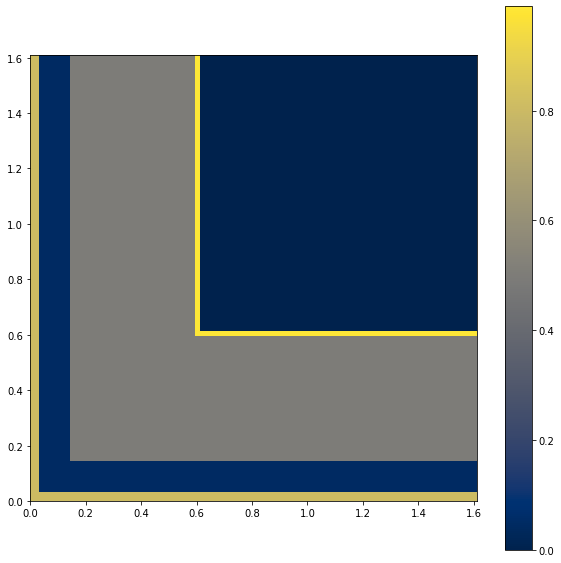

In [10]:
Display(K)

We will solve $\:\nabla\cdot(k\nabla T) = 0\:$

Expanding things:
<br>

$\cfrac{\partial}{\partial x}\Big(k_{(x,y)}\frac{\partial T}{\partial x}\Big) + \cfrac{\partial}{\partial y}\Big(k_{(x,y)}\frac{\partial T}{\partial y}\Big) = 0$

By the Product Rule:
<br>

$\cfrac{\partial k_{(x,y)}}{\partial x}\cfrac{\partial T}{\partial x} + k_{(x,y)}\cfrac{\partial^2 T}{\partial x^2}\;+\; \cfrac{\partial k_{(x,y)}}{\partial y}\cfrac{\partial T}{\partial y} + k_{(x,y)}\cfrac{\partial^2 T}{\partial y^2} = 0$

Regrouping:
<br>

$\cfrac{\partial k_{(x,y)}}{\partial x}\cfrac{\partial T}{\partial x} + \cfrac{\partial k_{(x,y)}}{\partial y}\cfrac{\partial T}{\partial y} + k_{(x,y)}\Big(\cfrac{\partial^2 T}{\partial x^2} + \cfrac{\partial^2 T}{\partial y^2}\Big) = 0$

Saving notation from now on, let:
<br>

$\begin{cases}
k_{(x,y)} = k\\
T_{(x,y)} = T\\\\
\lim\limits_{h\to 0} k_{(x+h,y)} = k^{+}_x\\
\lim\limits_{h\to 0} k_{(x,y+h)} = k^{+}_y\\ 
\lim\limits_{h\to 0} T_{(x+h,y)} = T^{+}_x\\ 
\lim\limits_{h\to 0} T_{(x-h,y)} = T^{-}_x\\
\lim\limits_{h\to 0} T_{(x,y+h)} = T^{+}_y\\ 
\lim\limits_{h\to 0} T_{(x,y-h)} = T^{-}_y\end{cases}$

Discretizing the equation:
<br>

$\cfrac{k^{+}_x - k}{h}\cdot\cfrac{T^{+}_x - T}{h} + \cfrac{k^{+}_y - k}{h}\cdot\cfrac{T^{+}_y - T}{h}
+k\cdot\cfrac{T^{+}_x - 2T + T^{-}_x + T^{+}_y - 2T + T^{-}_y}{h^2} = 0$

Expanding:
<br>

$k^{+}_x T^{+}_x - k^{+}_x T - k T^{+}_x + k T
+k^{+}_y T^{+}_y - k^{+}_y T - k T^{+}_y + k T
+k T^{+}_x - 2k T + k T^{-}_x
+k T^{+}_y - 2k T + k T^{-}_y = 0$

Which leads to:
<br>

$\cfrac{k^{+}_x T^{+}_x + k^{+}_y T^{+}_y + k T^{-}_x + k T^{-}_y}{k^{+}_x + 2k + k^{+}_y} - T = 0$

Written in matrix form:
<br>

$\cfrac{K[j,i+1]\cdot T[j,i+1] + K[j+1,i]\cdot T[j+1,i] + K[j,i]\cdot T[j,i-1] + K[j,i]\cdot T[j-1,i]}{K[j,i+1] + 2K[j,i] + K[j+1,i]} - T[j,i] = 0$

_____________

#### Boundary Conditions:
\**indexes go from 0 to n-1*

$T[n-1,i] - T[n-2,i] = 0\quad\quad\text{→ Neumann top}$
<br>

$T[j,n-1] - T[j,n-2] = 0\quad\quad\text{→ Neumann right}$
<br>

$T[j,0]\cdot K[j,0] + T[j,1]\cdot \Big( h \cdot k_{ex} - K[j,0]\Big) = h\cdot k_{ex}\cdot T_{ex}\quad\quad\:\:\text{→ Newton left}$
<br>

$T[0,i]\cdot K[0,i] + T[1,i]\cdot \Big( h \cdot k_{ex} - K[0,i]\Big) = h\cdot k_{ex}\cdot T_{ex}\quad\quad\:\:\;\text{→ Newton bottom}$
<br>

$T[j,\hat{i}]\cdot K[j,\hat{i}]+ T[j,\hat{i}-1]\cdot \Big( h \cdot k_{in} - K[j,\hat{i}]\Big) = h\cdot k_{in}\cdot T_{in}\quad\quad\text{→ Newton right-left}$
<br>

$T[\hat{j},i]\cdot K[\hat{j},i] + T[\hat{j}-1,i]\cdot \Big( h \cdot k_{in} - K[\hat{j},i]\Big) = h\cdot k_{in}\cdot T_{in}\quad\quad\text{→ Newton right-bottom}$

______

#### Assembling Matrix:
*(inside)*

In [11]:
def Mask(i, j, k, l):
    
    return ((l==i)&(k>=j-1)&(k<=j+1))|((k==j)&(l>=i-1)&(l<=i+1))

In [12]:
def Coeff(i, j, k, l):
    
    return (K[j,i+1])*(l==i+1)+(K[j+1,i])*(k==j+1)+(K[j,i])*(l==i-1)+(K[j,i])*(k==j-1)-(K[j,i+1]+2*K[j,i]+K[j+1,i])*((l==i)&(k==j))

In [13]:
M = fromfunction(lambda j, i, k, l: Coeff(i+1, j+1, k, l)*Mask(i+1, j+1, k, l), (n-2, n-2, n, n), dtype=int)

*(boundaries)*

In [14]:
M = vstack([zeros((1, n-2, n, n)), M, zeros((1, n-2 ,n, n))])
M = hstack([zeros((n,   1, n, n)), M, zeros((n,   1, n, n))])

In [15]:
T_ex = -11
k_ex =  25
T_in =  20
k_in =   6

In [16]:
î = argwhere(L < .61)[-1][0]
ĵ = î

In [17]:
Neu_top  = fromfunction(lambda i, k, l: (1)*((l==i)&(k==n-1))-((l==i)&(k==n-2)), (n, n, n), dtype=int)
Neu_rig  = fromfunction(lambda j, k, l: (1)*((k==j)&(l==n-1))-((k==j)&(l==n-2)), (n, n, n), dtype=int)

M[n-1, 1:î]  = Neu_top[1:î]
M[1:ĵ, n-1]  = Neu_rig[1:ĵ]

In [18]:
New_lef = fromfunction(lambda j, k, l: (K[j,0])*((k==j)&(l==0))+(h*k_ex - K[j,0])*((k==j)&(l==1)), (n, n, n), dtype=int)
New_bot = fromfunction(lambda i, k, l: (K[0,i])*((l==i)&(k==0))+(h*k_ex - K[0,i])*((l==i)&(k==1)), (n, n, n), dtype=int)

M[1:n-1, 0]  = New_lef[1:n-1]
M[0, 1:n-1]  = New_bot[1:n-1]

In [19]:
New_rle = fromfunction(lambda j, k, l: (K[j,î])*((k==j)&(l==î))+(h*k_in - K[j,î])*((k==j)&(l==î-1)), (n, n, n), dtype=int)
New_rbo = fromfunction(lambda i, k, l: (K[ĵ,i])*((l==i)&(k==ĵ))+(h*k_in - K[ĵ,i])*((l==i)&(k==ĵ-1)), (n, n, n), dtype=int)

M[ĵ+1:n-1, î]  = New_rle[ĵ+1:n-1]
M[ĵ, î+1:n-1]  = New_rbo[î+1:n-1]

In [20]:
F = zeros((n, n))

F[1:n-1,  0] = h * k_ex * T_ex
F[0,  1:n-1] = h * k_ex * T_ex
F[ĵ+1:n-1,î] = h * k_in * T_in
F[ĵ,î+1:n-1] = h * k_in * T_in

In [21]:
# corners

M[  0,  0] = zeros((n, n))
M[n-1,  0] = zeros((n, n))
M[n-1,  î] = zeros((n, n))
M[  ĵ,  î] = zeros((n, n))
M[  ĵ,n-1] = zeros((n, n))
M[  0,n-1] = zeros((n, n))

M[  0,  0,  0,  0] =  -1
M[  0,  0,  1,  0] = 1/2
M[  0,  0,  0,  1] = 1/2

M[n-1,  0,n-1,  0] =  -1
M[n-1,  0,n-1,  1] = 1/2
M[n-1,  0,n-2,  0] = 1/2

M[n-1,  î,n-1,  î] =  -1
M[n-1,  î,n-1,î-1] = 1/2
M[n-1,  î,n-2,  î] = 1/2

M[  ĵ,  î,  ĵ,  î] =  -1
M[  ĵ,  î,ĵ+1,  î] = 1/2
M[  ĵ,  î,  ĵ,î+1] = 1/2

M[  ĵ,n-1,  ĵ,n-1] =  -1
M[  ĵ,n-1,  ĵ,n-2] = 1/2
M[  ĵ,n-1,ĵ-1,n-1] = 1/2

M[  0,n-1,  0,n-1] =  -1
M[  0,n-1,  1,n-1] = 1/2
M[  0,n-1,  0,n-2] = 1/2

#### Solving:

In [22]:
L_Shape = argwhere(K > 0)

J = L_Shape[:,0]
I = L_Shape[:,1]

In [23]:
M = M[J,I][:,J,I]
F = F[J,I]

In [24]:
U = linear_solve(M, F)

In [25]:
T = full((n,n), T_in, dtype=float64)

In [26]:
T[J,I] = U

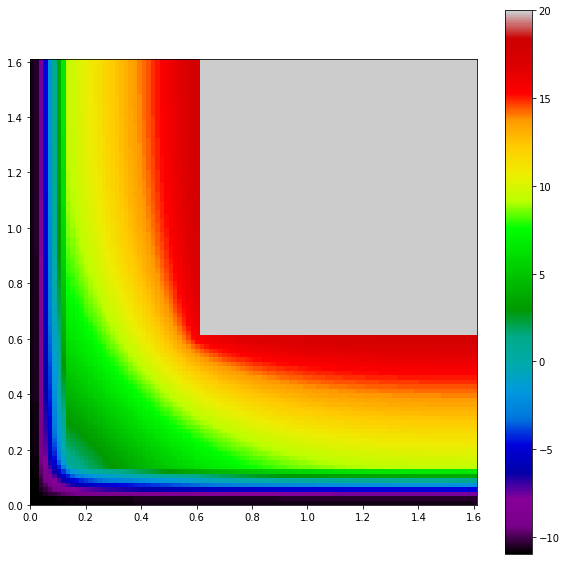

In [27]:
Display(T, 'nipy_spectral')